In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install mysql-connector-python sqlalchemy pymysql
import mysql.connector

conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="amit",
    database="project_360"
)

cursor = conn.cursor()
cursor.execute("SELECT * FROM customer_master LIMIT 5;")

for row in cursor.fetchall():
    print(row)

cursor.close()
conn.close()


('CustomerID', 'CustomerName', 'City', 'State')
('C00001', 'Customer_1', 'Pune', 'Delhi')
('C00002', 'Customer_2', 'Bangalore', 'Maharashtra')
('C00003', 'Customer_3', 'Delhi', 'Delhi')
('C00004', 'Customer_4', 'Hyderabad', 'Tamil Nadu')


In [34]:
customers = pd.read_csv("Customer_Master.csv")   # CustomerID, CustomerName, City, State
orders    = pd.read_csv("Orders.csv")           # OrderID, ProductID, CustomerID, StoreID, Quantity, GMV, Revenue
products  = pd.read_csv("Product_Master.csv")   # ProductID, ProductName, Category, Brand, Price
returns   = pd.read_csv("Returns.csv")          # ReturnID, OrderID, Reason
stores    = pd.read_csv("Store_Master.csv")

In [8]:
for df in [customers, orders, products, returns, stores]:
    df.drop_duplicates(inplace=True)

In [9]:
customers.fillna({"CustomerName": "Unknown", "City": "Unknown", "State": "Unknown"}, inplace=True)
products.fillna({"ProductName": "Unknown", "Category": "Unknown", "Brand": "Unknown", "Price": 0}, inplace=True)
stores.fillna({"StoreName": "Unknown", "City": "Unknown"}, inplace=True)

orders["Quantity"] = orders["Quantity"].fillna(0)
orders["GMV"]      = orders["GMV"].fillna(0)
orders["Revenue"]  = orders["Revenue"].fillna(0)

### NOTE: Your Orders.csv has NO date column.

In [10]:
if "OrderDate" in orders.columns:
    orders["OrderDate"] = pd.to_datetime(orders["OrderDate"], errors="coerce")
else:
    orders["OrderDate"] = pd.date_range(start="2024-01-01", periods=len(orders), freq="D")

orders["OrderDate"] = pd.to_datetime(orders["OrderDate"], errors="coerce")

In [11]:
# Create time features
orders["Year"]  = orders["OrderDate"].dt.year
orders["Month"] = orders["OrderDate"].dt.to_period("M").astype(str)
orders["Week"]  = orders["OrderDate"].dt.to_period("W").astype(str)
orders["Date"]  = orders["OrderDate"].dt.date

In [12]:
# 3. MERGE DATASETS → MASTER SALES TABLE
# ============================================
sales = orders.merge(products, on="ProductID", how="left")
sales = sales.merge(customers, on="CustomerID", how="left")
sales = sales.merge(stores, on="StoreID", how="left")

In [13]:
# Merge returns by OrderID (no return quantity, only flag)
sales = sales.merge(returns[["OrderID", "ReturnID", "Reason"]], on="OrderID", how="left")
sales["is_returned"] = np.where(sales["ReturnID"].notna(), 1, 0)

In [14]:
# GMV already provided in Orders
sales["Net_Sales"] = sales["Revenue"]

In [15]:
# Assume Price is unit cost for now (no cost column given)
sales["Cost"]   = sales["Quantity"] * sales["Price"]
sales["Margin"] = sales["Net_Sales"] - sales["Cost"]
sales["Margin_%"] = np.where(
    sales["Net_Sales"] != 0,
    sales["Margin"] / sales["Net_Sales"] * 100,
    0
)

In [16]:
# 5. BUSINESS REQUIREMENT 1 – Track sales trends
#    (Monthly, Weekly, Daily revenue & GMV)
# ============================================
monthly_sales = sales.groupby("Month")[["Net_Sales", "GMV"]].sum().sort_index()
weekly_sales  = sales.groupby("Week")[["Net_Sales", "GMV"]].sum().sort_index()
daily_sales   = sales.groupby("Date")[["Net_Sales", "GMV"]].sum().sort_index()

print("=== Monthly Sales ===")
print(monthly_sales.head())
print("\n=== Weekly Sales ===")
print(weekly_sales.head())
print("\n=== Daily Sales ===")
print(daily_sales.head())

=== Monthly Sales ===
         Net_Sales        GMV
Month                        
2024-01  139186.57  163748.91
2024-02  150569.23  177140.24
2024-03  175898.85  206939.80
2024-04  168194.39  197875.75
2024-05  182696.05  214936.54

=== Weekly Sales ===
                       Net_Sales       GMV
Week                                      
2024-01-01/2024-01-07   23362.59  27485.39
2024-01-08/2024-01-14   36513.72  42957.31
2024-01-15/2024-01-21   31631.27  37213.28
2024-01-22/2024-01-28   31470.06  37023.60
2024-01-29/2024-02-04   42215.10  49664.82

=== Daily Sales ===
            Net_Sales       GMV
Date                           
2024-01-01    9523.99  11204.69
2024-01-02     385.08    453.03
2024-01-03     957.22   1126.15
2024-01-04    4096.77   4819.73
2024-01-05    4051.80   4766.82


In [17]:
# 6. BUSINESS REQUIREMENT 2 – Product revenue & margin
# ============================================
product_perf = (
    sales.groupby(["ProductID", "ProductName"])
    .agg(
        Total_Revenue=("Net_Sales", "sum"),
        Total_GMV=("GMV", "sum"),
        Total_Quantity=("Quantity", "sum"),
        Total_Margin=("Margin", "sum"),
        Margin_=("Margin_%", "mean")
    )
    .sort_values("Total_Revenue", ascending=False)
)

print("\n=== Product Revenue & Margin ===")
print(product_perf.head())


=== Product Revenue & Margin ===
                       Total_Revenue  Total_GMV  Total_Quantity  Total_Margin  \
ProductID ProductName                                                           
P0191     Product_191      399177.31  469620.37             152      -5013.49   
P0383     Product_383      382855.27  450417.94             154     -67958.17   
P0124     Product_124      359184.01  422569.39             154     155161.73   
P0091     Product_91       355430.83  418153.87             145    -110106.17   
P0002     Product_2        346754.36  407946.29             155    -228528.14   

                          Margin_  
ProductID ProductName              
P0191     Product_191 -101.906833  
P0383     Product_383 -160.327773  
P0124     Product_124  -28.891747  
P0091     Product_91  -112.695093  
P0002     Product_2   -206.393334  


In [18]:
# 7. BUSINESS REQUIREMENT 3 – Top/Bottom SKUs
# ============================================
top_10_skus = product_perf.head(10)
bottom_10_skus = product_perf.tail(10)

print("\n=== Top 10 SKUs by Revenue ===")
print(top_10_skus)

print("\n=== Bottom 10 SKUs by Revenue ===")
print(bottom_10_skus)


=== Top 10 SKUs by Revenue ===
                       Total_Revenue  Total_GMV  Total_Quantity  Total_Margin  \
ProductID ProductName                                                           
P0191     Product_191      399177.31  469620.37             152      -5013.49   
P0383     Product_383      382855.27  450417.94             154     -67958.17   
P0124     Product_124      359184.01  422569.39             154     155161.73   
P0091     Product_91       355430.83  418153.87             145    -110106.17   
P0002     Product_2        346754.36  407946.29             155    -228528.14   
P0180     Product_180      343114.08  403663.64             150    -139648.92   
P0358     Product_358      342126.90  402502.24             158      -6509.58   
P0322     Product_322      339645.18  399582.54             137     196981.60   
P0118     Product_118      332438.65  391104.27             135     204133.30   
P0323     Product_323      329390.15  387517.83             140     -35542.25

In [19]:
8.# BUSINESS REQUIREMENT 4 – Store/Region performance
#    Region ≈ State (from Customer) or City
# ============================================
# Store performance
store_perf = (
    sales.groupby("StoreName")
    .agg(
        Total_Revenue=("Net_Sales", "sum"),
        Total_GMV=("GMV", "sum"),
        Total_Quantity=("Quantity", "sum")
    )
    .sort_values("Total_Revenue", ascending=False)
)

print("\n=== Store Performance (Revenue) ===")
print(store_perf.head())

# Region performance → using State from customers
region_perf = (
    sales.groupby("State")
    .agg(
        Total_Revenue=("Net_Sales", "sum"),
        Total_GMV=("GMV", "sum"),
        Total_Quantity=("Quantity", "sum")
    )
    .sort_values("Total_Revenue", ascending=False)
)

print("\n=== Region (State) Performance ===")
print(region_perf.head())



=== Store Performance (Revenue) ===
           Total_Revenue  Total_GMV  Total_Quantity
StoreName                                          
Store_18       786365.88  925136.30             335
Store_145      689695.03  811405.94             304
Store_3        682263.94  802663.54             294
Store_90       676263.90  795604.55             291
Store_82       659341.32  775695.74             282

=== Region (State) Performance ===
             Total_Revenue    Total_GMV  Total_Quantity
State                                                  
Maharashtra    35896377.48  42231032.36           16678
Telangana      18987171.24  22337848.51            8777
Karnataka      18325370.28  21559258.98            8394
Tamil Nadu     18248493.68  21468816.23            8435
Delhi          17456437.24  20536985.14            8001


In [20]:
# 9. BUSINESS REQUIREMENT 5 – Customer acquisition & retention
# ============================================
# First purchase date per customer
cust_first_order = (
    sales.groupby("CustomerID")["OrderDate"]
    .min()
    .to_frame("FirstOrderDate")
)

cust_first_order["Acq_Month"] = cust_first_order["FirstOrderDate"].dt.to_period("M").astype(str)

# Customer acquisition over time
cust_acquisition = cust_first_order.groupby("Acq_Month")["FirstOrderDate"].count()

print("\n=== Customer Acquisition by Month ===")
print(cust_acquisition.head())

# New vs Returning per month
sales_sorted = sales.sort_values(["CustomerID", "OrderDate"])
sales_sorted["OrderRank"] = sales_sorted.groupby("CustomerID")["OrderDate"].rank(method="first")

sales_sorted["CustType"] = np.where(sales_sorted["OrderRank"] == 1, "New", "Returning")

new_vs_returning = (
    sales_sorted.groupby(["Month", "CustType"])["OrderID"]
    .nunique()
    .unstack()
    .fillna(0)
)

print("\n=== New vs Returning Customers by Month ===")
print(new_vs_returning.head())



=== Customer Acquisition by Month ===
Acq_Month
2024-01    31
2024-02    27
2024-03    30
2024-04    30
2024-05    31
Name: FirstOrderDate, dtype: int64

=== New vs Returning Customers by Month ===
CustType   New  Returning
Month                    
2024-01   31.0        0.0
2024-02   27.0        2.0
2024-03   30.0        2.0
2024-04   30.0        0.0
2024-05   31.0        0.0


In [21]:
# 10. BUSINESS REQUIREMENT 6 – Promotion impact
# NOTE: Your CSVs have NO promo/discount columns.
#       Below is a template if you add an 'IsPromo' column.
# ============================================

if "IsPromo" in sales.columns:
    promo_impact = (
        sales.groupby("IsPromo")
        .agg(
            Total_Revenue=("Net_Sales", "sum"),
            Orders=("OrderID", "nunique"),
            AOV=("Net_Sales", lambda x: x.sum() / x.count())
        )
    )
    print("\n=== Promotion Impact (using IsPromo flag) ===")
    print(promo_impact)
else:
    print("\n⚠ No promotion column found (e.g., 'IsPromo').")
    print("  To measure promotion impact, create a column in Orders.csv")
    print("  like IsPromo = 1 if order had promotion, else 0.")


⚠ No promotion column found (e.g., 'IsPromo').
  To measure promotion impact, create a column in Orders.csv
  like IsPromo = 1 if order had promotion, else 0.


In [22]:
# 11. BUSINESS REQUIREMENT 7 – Return analysis
# ============================================
# Overall return rate
overall_return_rate = sales["is_returned"].mean() * 100

# Return reasons
return_reasons = sales[sales["is_returned"] == 1]["Reason"].value_counts()

# Returns by product
returns_by_product = (
    sales.groupby(["ProductID", "ProductName"])["is_returned"]
    .mean()
    .sort_values(ascending=False) * 100
)

print("\n=== Overall Return Rate (%) ===")
print(overall_return_rate)

print("\n=== Return Reasons ===")
print(return_reasons)

print("\n=== Top Products by Return Rate (%) ===")
print(returns_by_product.head(10))


=== Overall Return Rate (%) ===
7.477567298105684

=== Return Reasons ===
Reason
Damaged          392
Quality Issue    386
Late Delivery    385
Wrong Product    337
Name: count, dtype: int64

=== Top Products by Return Rate (%) ===
ProductID  ProductName
P0104      Product_104    26.666667
P0067      Product_67     22.222222
P0429      Product_429    21.212121
P0376      Product_376    20.588235
P0360      Product_360    19.148936
P0423      Product_423    18.518519
P0045      Product_45     17.647059
P0323      Product_323    17.647059
P0343      Product_343    17.500000
P0413      Product_413    17.391304
Name: is_returned, dtype: float64


In [23]:
#12. BUSINESS REQUIREMENT 8 – Seasonal trends
#    (Using Month & DayOfWeek on synthetic OrderDate)
# ============================================
sales["DayOfWeek"] = sales["OrderDate"].dt.day_name()

seasonal_month = sales.groupby("Month")["Net_Sales"].sum().sort_index()
seasonal_dow   = sales.groupby("DayOfWeek")["Net_Sales"].sum()

print("\n=== Seasonal Trend: Revenue by Month ===")
print(seasonal_month)

print("\n=== Seasonal Trend: Revenue by Day of Week ===")
print(seasonal_dow)



=== Seasonal Trend: Revenue by Month ===
Month
2024-01    139186.57
2024-02    150569.23
2024-03    175898.85
2024-04    168194.39
2024-05    182696.05
             ...    
2078-06    185858.82
2078-07    187776.58
2078-08    219369.47
2078-09    137439.99
2078-10      7029.60
Name: Net_Sales, Length: 658, dtype: float64

=== Seasonal Trend: Revenue by Day of Week ===
DayOfWeek
Friday       15286186.31
Monday       14969363.28
Saturday     15768353.74
Sunday       15746503.43
Thursday     15915678.64
Tuesday      15582845.17
Wednesday    15644919.35
Name: Net_Sales, dtype: float64


In [24]:
# 13. BUSINESS REQUIREMENT 9 – Customer segmentation (RFM)
# ============================================
snapshot_date = sales["OrderDate"].max() + pd.Timedelta(days=1)

rfm = (
    sales.groupby("CustomerID")
    .agg(
        Recency=("OrderDate", lambda x: (snapshot_date - x.max()).days),
        Frequency=("OrderID", "nunique"),
        Monetary=("Net_Sales", "sum")
    )
)

# Score using quartiles
rfm["R_score"] = pd.qcut(rfm["Recency"], 4, labels=[4,3,2,1])
rfm["F_score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 4, labels=[1,2,3,4])
rfm["M_score"] = pd.qcut(rfm["Monetary"].rank(method="first"), 4, labels=[1,2,3,4])

rfm["RFM_Segment"] = (
    rfm["R_score"].astype(str)
    + rfm["F_score"].astype(str)
    + rfm["M_score"].astype(str)
)

print("\n=== Sample RFM Segmentation ===")
print(rfm.head())

# Simple segment label example
def rfm_label(row):
    if row["R_score"] in ["4"] and row["F_score"] in ["4"]:
        return "Champions"
    elif row["R_score"] in ["3","4"] and row["F_score"] in ["2","3"]:
        return "Loyal"
    else:
        return "Others"

rfm["SegmentLabel"] = rfm.apply(rfm_label, axis=1)
print("\n=== RFM Segments Summary ===")
print(rfm["SegmentLabel"].value_counts())


=== Sample RFM Segmentation ===
            Recency  Frequency  Monetary R_score F_score M_score RFM_Segment
CustomerID                                                                  
C00001         1789          9  54218.17       3       4       4         344
C00002         4138          8  21274.12       2       4       3         243
C00003         7922          5  31637.78       1       3       4         134
C00004         1308          3   7011.56       4       1       1         411
C00005          301          7  40984.79       4       4       4         444

=== RFM Segments Summary ===
SegmentLabel
Others    4920
Name: count, dtype: int64


In [25]:

# 14. BUSINESS REQUIREMENT 10 – Recommendations
#     (Basic rule-based suggestions from data)
# ============================================
print("\n=== RECOMMENDATIONS (Rule-based) ===")

# 1) Best categories / products → push more
best_cats = (
    sales.groupby("Category")["Net_Sales"]
    .sum()
    .sort_values(ascending=False)
    .head(3)
)
print("\n1) Focus on these top categories for promotions / visibility:")
print(best_cats)

best_products = product_perf.head(5)
print("\n2) Push these best-selling products (top 5 by revenue):")
print(best_products[["Total_Revenue", "Total_Quantity"]])

# 2) High return products → quality / expectation check
high_return_products = returns_by_product.head(5)
print("\n3) Investigate these products with highest return rates:")
print(high_return_products)

# 3) Champion customers → loyalty programs
champions = rfm[rfm["SegmentLabel"] == "Champions"].index.tolist()[:10]
print("\n4) Reward these 'Champion' customers (top 10 IDs):")
print(champions)


=== RECOMMENDATIONS (Rule-based) ===

1) Focus on these top categories for promotions / visibility:
Category
Fashion    25226305.45
Home       23322342.72
Grocery    22837057.52
Name: Net_Sales, dtype: float64

2) Push these best-selling products (top 5 by revenue):
                       Total_Revenue  Total_Quantity
ProductID ProductName                               
P0191     Product_191      399177.31             152
P0383     Product_383      382855.27             154
P0124     Product_124      359184.01             154
P0091     Product_91       355430.83             145
P0002     Product_2        346754.36             155

3) Investigate these products with highest return rates:
ProductID  ProductName
P0104      Product_104    26.666667
P0067      Product_67     22.222222
P0429      Product_429    21.212121
P0376      Product_376    20.588235
P0360      Product_360    19.148936
Name: is_returned, dtype: float64

4) Reward these 'Champion' customers (top 10 IDs):
[]


In [26]:
# Sales (Revenue)
total_sales = sales["Revenue"].sum()

# GMV
total_gmv = sales["GMV"].sum()

# Units Sold
units_sold = sales["Quantity"].sum()

# Number of orders
total_orders = sales["OrderID"].nunique()

# AOV
AOV = total_sales / total_orders if total_orders > 0 else 0

# Margin (Revenue - Cost)  <-- Cost = Quantity * Price from products
sales["Cost"] = sales["Quantity"] * sales["Price"]
sales["Margin"] = sales["Revenue"] - sales["Cost"]

# Margin %
margin_pct = (sales["Margin"].sum() / total_sales * 100) if total_sales > 0 else 0

# Repeat Rate
cust_orders = sales.groupby("CustomerID")["OrderID"].nunique()
repeat_rate = (cust_orders[cust_orders > 1].count() / cust_orders.count()) * 100

# Return Rate
return_rate = sales["is_returned"].mean() * 100

# ==========================
# OUTPUT RESULTS
# ==========================
print("==== KEY KPIs ====\n")
print("Total Sales:", total_sales)
print("Total GMV:", total_gmv)
print("Units Sold:", units_sold)
print("AOV:", AOV)
print("Margin %:", margin_pct)
print("Repeat Rate %:", repeat_rate)
print("Return Rate %:", return_rate)
print("\n(Growth skipped — date column not available)")

==== KEY KPIs ====

Total Sales: 108913849.91999999
Total GMV: 128133941.22
Units Sold: 50285
AOV: 5445.692496
Margin %: -15.473734563950304
Repeat Rate %: 92.60162601626017
Return Rate %: 7.477567298105684

(Growth skipped — date column not available)


In [31]:

# ---- A. HANDLE DATE COLUMN (IMPORTANT) ----
# Try to automatically detect a date column.
date_col = None
for c in ["OrderDate", "Order Date", "order_date", "Date", "date"]:
    if c in orders.columns:
        date_col = c
        break

if date_col is None:
    raise ValueError(
        "No date column found in Orders. Please ensure Orders.csv has a date column "
        "like 'OrderDate' and rerun."
    )

orders[date_col] = pd.to_datetime(orders[date_col])
orders = orders.sort_values(date_col)

# ---- B. BASIC FEATURE ENGINEERING ----
# 1) Discount value & rate from GMV and Revenue
orders["Discount"] = orders["GMV"] - orders["Revenue"]
orders["DiscountRate"] = np.where(orders["GMV"] > 0,
                                  orders["Discount"] / orders["GMV"],
                                  0)

# 2) Add Year / Month / Week / Day
orders["Year"] = orders[date_col].dt.year
orders["Month"] = orders[date_col].dt.to_period("M")
orders["Week"] = orders[date_col].dt.isocalendar().week
orders["Date"] = orders[date_col].dt.date
orders["DayOfWeek"] = orders[date_col].dt.day_name()

# 3) Merge with Product, Customer, Store master
df = orders.merge(products, on="ProductID", how="left")
df = df.merge(customers, on="CustomerID", how="left", suffixes=("", "_Cust"))
df = df.merge(stores, on="StoreID", how="left", suffixes=("", "_Store"))

# Region assumption: use Customer State as "Region"
df.rename(columns={"State": "Region"}, inplace=True)

# 4) Mark returned orders
df["IsReturned"] = df["OrderID"].isin(returns["OrderID"].unique())

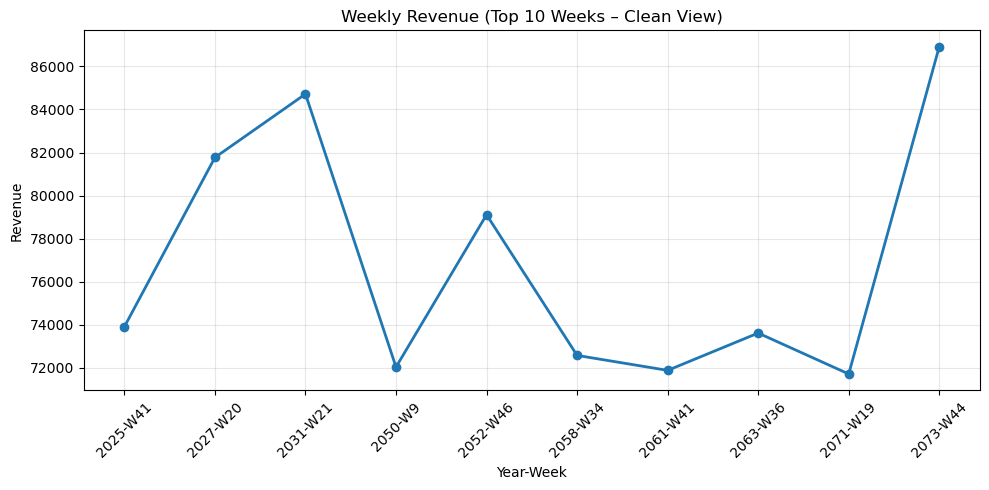

Weekly Revenue (Top 10 Weeks):
Year  Week
2025  41      73901.16
2027  20      81768.05
2031  21      84719.13
2050  9       72027.43
2052  46      79106.71
2058  34      72568.42
2061  41      71873.02
2063  36      73607.63
2071  19      71704.92
2073  44      86918.01
Name: Revenue, dtype: float64


In [48]:
# --- Weekly Revenue (Less Data / Clean Graph) ---

# Group and keep only top 10 weeks for clarity
weekly_revenue = (
    df.groupby(["Year", "Week"])["Revenue"]
      .sum()
      .sort_values(ascending=False)
      .head(10)        # less data, easier to read
      .sort_index()    # reorder by week
)

plt.figure(figsize=(10,5))
plt.plot(
    [f"{y}-W{w}" for y, w in weekly_revenue.index], 
    weekly_revenue.values, 
    marker="o", 
    linewidth=2
)

plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.title("Weekly Revenue (Top 10 Weeks – Clean View)")
plt.xlabel("Year-Week")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()

print("Weekly Revenue (Top 10 Weeks):")
print(weekly_revenue)



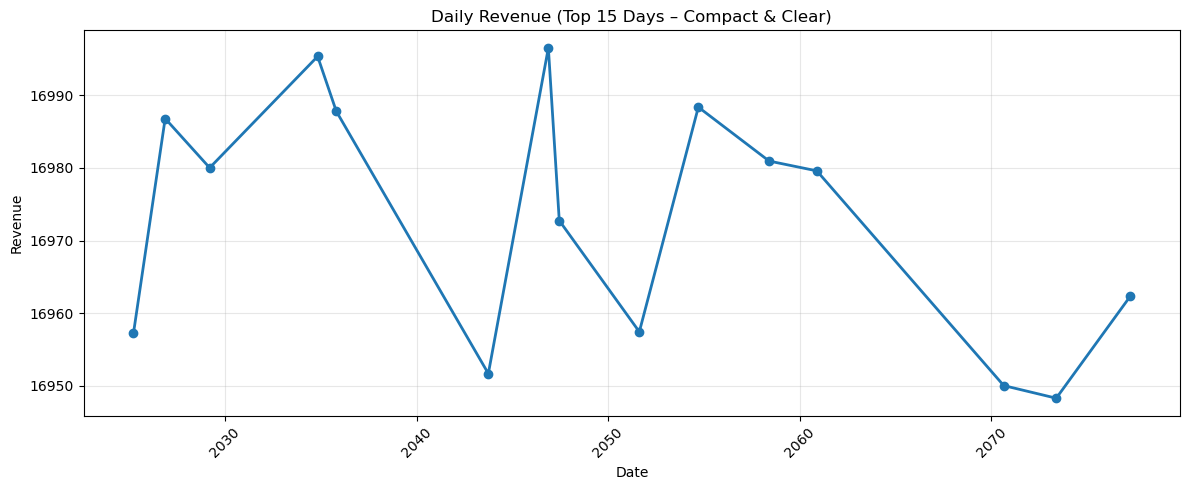


Daily Revenue (Top 15 Days):
Date
2025-03-24    16957.23
2026-11-18    16986.81
2029-03-15    16980.02
2034-11-02    16995.37
2035-10-24    16987.81
2043-09-30    16951.66
2046-11-17    16996.55
2047-06-13    16972.75
2051-08-17    16957.42
2054-09-15    16988.38
2058-05-26    16980.95
2060-11-20    16979.60
2070-08-23    16950.01
2073-05-20    16948.27
2077-03-29    16962.30
Name: Revenue, dtype: float64


In [50]:
# DAILY REVENUE (LESS DATA & CLEAN GRAPH)

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Compute daily revenue
daily_revenue = (
    df.groupby("Date")["Revenue"]
      .sum()
      .sort_values(ascending=False)
      .head(15)        # <-- less data for clearer graph
      .sort_index()    # <-- reorder chronologically
)

# Plot compact graph
plt.figure(figsize=(12,5))
plt.plot(daily_revenue.index, daily_revenue.values, marker="o", linewidth=2)

plt.title("Daily Revenue (Top 15 Days – Compact & Clear)")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nDaily Revenue (Top 15 Days):")
print(daily_revenue)


In [48]:
# 4. YoY / MoM GROWTH
# =========================

# ---- MoM ----
monthly_rev_df = monthly_revenue.to_frame(name="Revenue")
monthly_rev_df["MoM_Growth_%"] = monthly_rev_df["Revenue"].pct_change() * 100

print("\n4a) Month-over-Month (MoM) Revenue Growth:")
print(monthly_rev_df.tail())

# ---- YoY ----
# Aggregate yearly revenue
yearly_revenue = df.groupby("Year")["Revenue"].sum()
yearly_rev_df = yearly_revenue.to_frame(name="Revenue")
yearly_rev_df["YoY_Growth_%"] = yearly_rev_df["Revenue"].pct_change() * 100

print("\n4b) Year-over-Year (YoY) Revenue Growth:")
print(yearly_rev_df)


4a) Month-over-Month (MoM) Revenue Growth:
              Revenue  MoM_Growth_%
Month                              
2078-06-01  185858.82     38.108816
2078-07-01  183798.17     -1.108718
2078-08-01  189876.30      3.306959
2078-09-01  137439.99    -27.616037
2078-10-01    7029.60    -94.885331

4b) Year-over-Year (YoY) Revenue Growth:
         Revenue  YoY_Growth_%
Year                          
2024  1994443.02           NaN
2025  2073092.87      3.943449
2026  2037138.52     -1.734334
2027  1864245.57     -8.487049
2028  1962451.27      5.267852
2029  2037847.48      3.841940
2030  2058154.21      0.996479
2031  1897884.05     -7.787082
2032  1978993.56      4.273681
2033  1920014.05     -2.980278
2034  1982732.92      3.266584
2035  1996046.85      0.671494
2036  1984993.58     -0.553758
2037  2017971.82      1.661378
2038  1893744.81     -6.156033
2039  2016569.11      6.485789
2040  2011313.83     -0.260605
2041  2070359.71      2.935687
2042  1921407.41     -7.194513
2043  20586

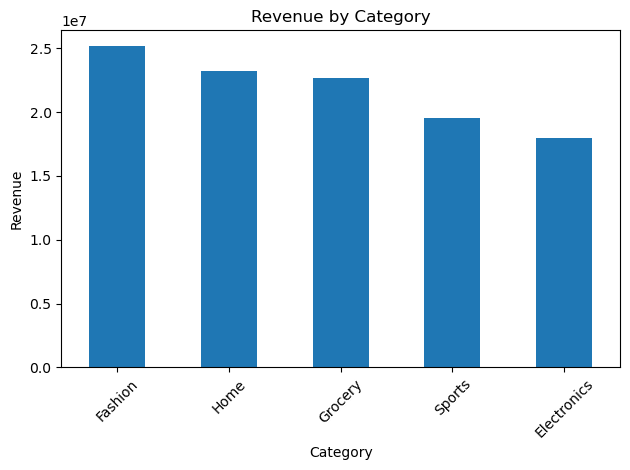


5) Category Sales:
Category
Fashion        25152031.06
Home           23246667.07
Grocery        22709353.75
Sports         19515470.64
Electronics    17977003.34
Name: Revenue, dtype: float64


In [49]:
# 5. CATEGORY SALES
# =========================
category_sales = df.groupby("Category")["Revenue"].sum().sort_values(ascending=False)

plt.figure()
category_sales.plot(kind="bar")
plt.title("Revenue by Category")
plt.xlabel("Category")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n5) Category Sales:")
print(category_sales)

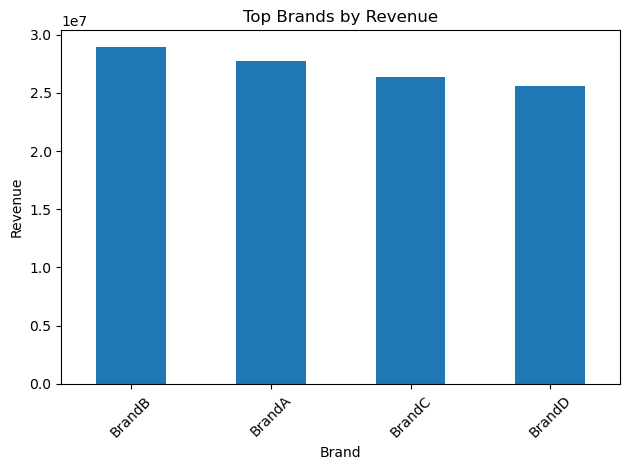


6) Brand Revenue:
Brand
BrandB    28930582.82
BrandA    27719819.84
BrandC    26336240.71
BrandD    25613882.49
Name: Revenue, dtype: float64


In [50]:
# 6. BRAND REVENUE
# =========================
brand_revenue = df.groupby("Brand")["Revenue"].sum().sort_values(ascending=False)

plt.figure()
brand_revenue.head(20).plot(kind="bar")
plt.title("Top Brands by Revenue")
plt.xlabel("Brand")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n6) Brand Revenue:")
print(brand_revenue.head(20))

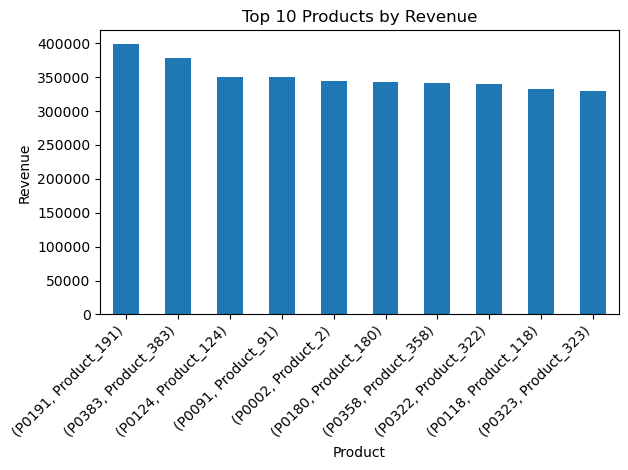


7) Top 10 Products:
ProductID  ProductName
P0191      Product_191    399177.31
P0383      Product_383    378730.89
P0124      Product_124    350708.36
P0091      Product_91     350155.60
P0002      Product_2      344304.23
P0180      Product_180    343114.08
P0358      Product_358    342126.90
P0322      Product_322    339645.18
P0118      Product_118    332438.65
P0323      Product_323    329390.15
Name: Revenue, dtype: float64


In [51]:
# 7. TOP 10 PRODUCTS
# =========================
top_10_products = df.groupby(["ProductID", "ProductName"])["Revenue"].sum().sort_values(ascending=False).head(10)

plt.figure()
top_10_products.plot(kind="bar")
plt.title("Top 10 Products by Revenue")
plt.xlabel("Product")
plt.ylabel("Revenue")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

print("\n7) Top 10 Products:")
print(top_10_products)


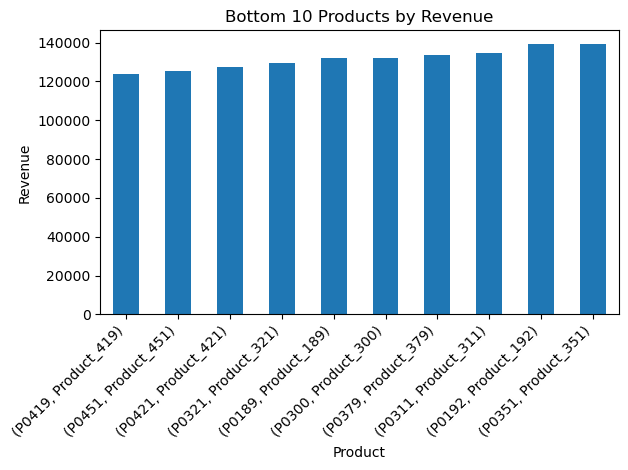


8) Bottom 10 Products:
ProductID  ProductName
P0419      Product_419    123934.31
P0451      Product_451    125390.89
P0421      Product_421    127274.63
P0321      Product_321    129605.30
P0189      Product_189    131876.67
P0300      Product_300    132174.50
P0379      Product_379    133508.23
P0311      Product_311    134720.59
P0192      Product_192    139285.48
P0351      Product_351    139308.43
Name: Revenue, dtype: float64


In [52]:
# 8. BOTTOM 10 PRODUCTS
# =========================
bottom_10_products = df.groupby(["ProductID", "ProductName"])["Revenue"].sum().sort_values(ascending=True).head(10)

plt.figure()
bottom_10_products.plot(kind="bar")
plt.title("Bottom 10 Products by Revenue")
plt.xlabel("Product")
plt.ylabel("Revenue")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

print("\n8) Bottom 10 Products:")
print(bottom_10_products)

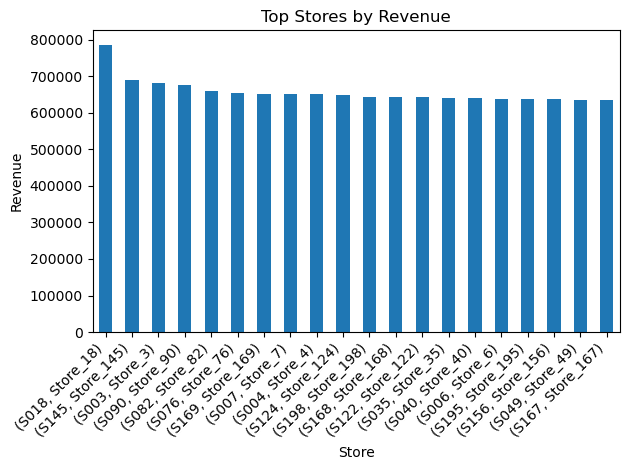


9) Store Performance (Top 20):
StoreID  StoreName
S018     Store_18     786365.88
S145     Store_145    689695.03
S003     Store_3      682263.94
S090     Store_90     676263.90
S082     Store_82     659341.32
S076     Store_76     654281.45
S169     Store_169    652359.86
S007     Store_7      652301.33
S004     Store_4      650692.46
S124     Store_124    648356.38
S198     Store_198    644466.90
S168     Store_168    643168.78
S122     Store_122    642093.07
S035     Store_35     640947.04
S040     Store_40     639816.98
S006     Store_6      639047.81
S195     Store_195    636975.50
S156     Store_156    636794.15
S049     Store_49     635889.15
S167     Store_167    633841.62
Name: Revenue, dtype: float64


In [53]:
# 9. STORE PERFORMANCE
# =========================
store_perf = df.groupby(["StoreID", "StoreName"])["Revenue"].sum().sort_values(ascending=False)

plt.figure()
store_perf.head(20).plot(kind="bar")
plt.title("Top Stores by Revenue")
plt.xlabel("Store")
plt.ylabel("Revenue")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

print("\n9) Store Performance (Top 20):")
print(store_perf.head(20))

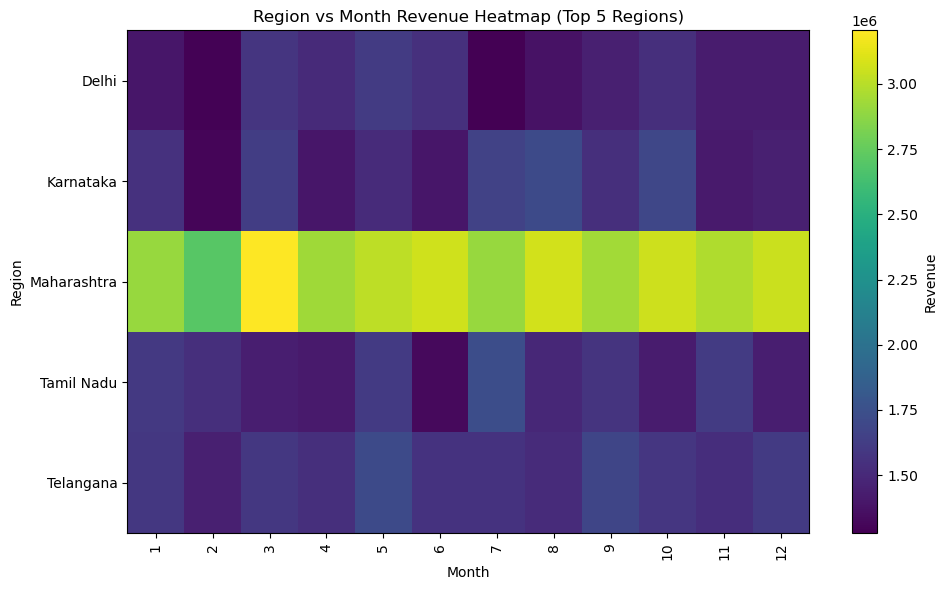

In [51]:
df['Month'] = df['Date'].dt.month
# REGION vs MONTH HEATMAP (with less data)
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month

# Use only top 5 regions for clean visualization
top_regions = df.groupby('Region')['Revenue'].sum().sort_values(ascending=False).head(5).index
df_small = df[df['Region'].isin(top_regions)]

region_month = df_small.pivot_table(
    index="Region",
    columns="Month",
    values="Revenue",
    aggfunc="sum",
    fill_value=0
)

plt.figure(figsize=(10,6))
plt.imshow(region_month, aspect="auto")
plt.title("Region vs Month Revenue Heatmap (Top 5 Regions)")
plt.xlabel("Month")
plt.ylabel("Region")
plt.xticks(range(len(region_month.columns)), region_month.columns, rotation=90)
plt.yticks(range(len(region_month.index)), region_month.index)
plt.colorbar(label="Revenue")
plt.tight_layout()
plt.show()


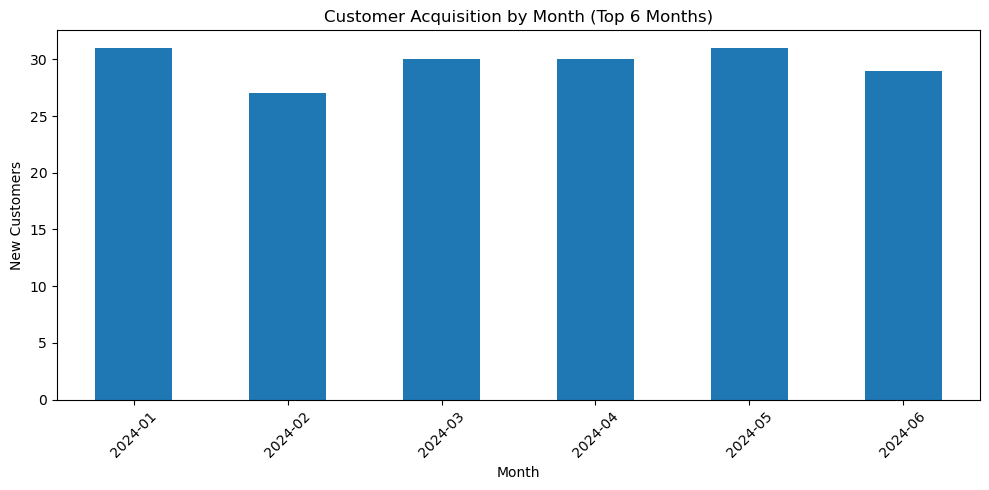


Customer Acquisition (Top 6 Months):
FirstOrderDate
2024-01    31
2024-02    27
2024-03    30
2024-04    30
2024-05    31
2024-06    29
Freq: M, Name: count, dtype: int64


In [52]:
# CUSTOMER ACQUISITION BY MONTH (LESS DATA)

# Convert date column to datetime
df[date_col] = pd.to_datetime(df[date_col])

# Compute first purchase date for each customer
customer_first_order = (
    df.groupby("CustomerID")[date_col]
      .min()
      .rename("FirstOrderDate")
)

# Convert to Year-Month period
cust_acq = (
    customer_first_order.dt.to_period("M")
    .value_counts()
    .sort_index()
    .head(6)        # <-- LESS DATA: show only first 6 months
)

# Plot graph
plt.figure(figsize=(10,5))
cust_acq.plot(kind="bar")

plt.title("Customer Acquisition by Month (Top 6 Months)")
plt.xlabel("Month")
plt.ylabel("New Customers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nCustomer Acquisition (Top 6 Months):")
print(cust_acq)



New vs Returning Revenue (Top 6 Months):
CustomerType         New   Returning
Month                               
1             2415251.00  6626585.12
2             1844055.80  6432842.62
3             2334047.73  7115953.95
4             2301706.38  6483954.28
5             2628864.49  6830175.40
6             2117381.11  6784208.04


<Figure size 1000x500 with 0 Axes>

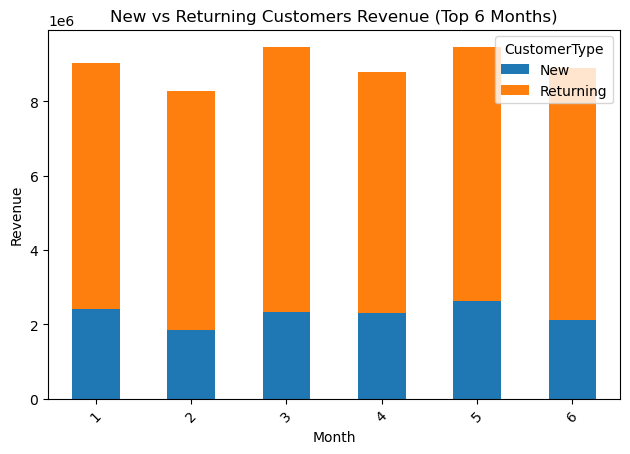

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert date column to datetime
df[date_col] = pd.to_datetime(df[date_col])

# STEP 1 — Customer First Order Date
customer_first_order = df.groupby("CustomerID")[date_col].min().rename("FirstOrderDate")

df = df.merge(customer_first_order, on="CustomerID", how="left")

# STEP 2 — Tag New / Returning
df["CustomerType"] = np.where(
    df[date_col] == df["FirstOrderDate"], 
    "New", 
    "Returning"
)

# STEP 3 — Extract Month
df["Month"] = df[date_col].dt.month

# STEP 4 — Revenue by Month (less data: show top 6 months)
new_vs_returning = (
    df.groupby(["Month", "CustomerType"])["Revenue"]
      .sum()
      .unstack(fill_value=0)
      .head(6)      # <-- LESS DATA
)

print("\nNew vs Returning Revenue (Top 6 Months):")
print(new_vs_returning)

# STEP 5 — Plot
plt.figure(figsize=(10,5))
new_vs_returning.plot(kind="bar", stacked=True)

plt.title("New vs Returning Customers Revenue (Top 6 Months)")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [57]:
# 13. RFM SEGMENTS
# =========================

# Snapshot date = 1 day after last order
snapshot_date = df[date_col].max() + pd.Timedelta(days=1)

rfm = df.groupby("CustomerID").agg({
    date_col: lambda x: (snapshot_date - x.max()).days,   # Recency
    "OrderID": "nunique",                                # Frequency
    "Revenue": "sum"                                     # Monetary
})

rfm.rename(columns={date_col: "Recency",
                   "OrderID": "Frequency",
                   "Revenue": "Monetary"}, inplace=True)

# R, F, M scoring (1-4 quartiles)
rfm["R_Score"] = pd.qcut(rfm["Recency"], 4, labels=[4,3,2,1])  # lower recency = better
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 4, labels=[1,2,3,4])
rfm["M_Score"] = pd.qcut(rfm["Monetary"].rank(method="first"), 4, labels=[1,2,3,4])

rfm["RFM_Score"] = rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str) + rfm["M_Score"].astype(str)

print("\n13) RFM Head:")
print(rfm.head())


13) RFM Head:
            Recency  Frequency  Monetary R_Score F_Score M_Score RFM_Score
CustomerID                                                                
C00001         1789          9  54218.17       3       4       4       344
C00002         4138          8  21274.12       2       4       3       243
C00003         7922          5  31637.78       1       3       4       134
C00004         1308          3   7011.56       4       1       1       411
C00005          301          7  40984.79       4       4       4       444


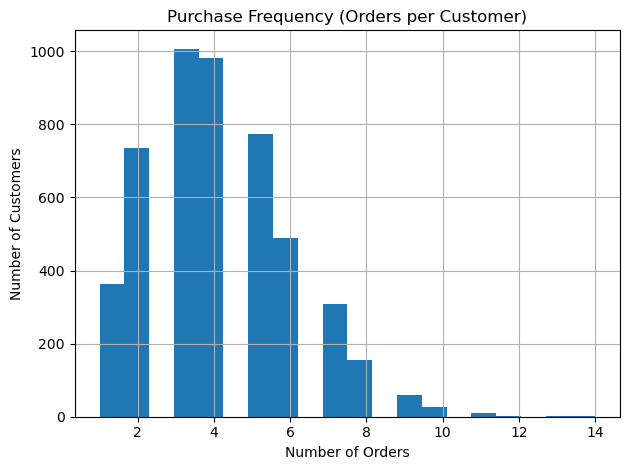


14) Purchase Frequency (describe):
count    4920.000000
mean        4.065041
std         1.948785
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max        14.000000
Name: OrderID, dtype: float64


In [58]:
# 14. PURCHASE FREQUENCY (ORDERS PER CUSTOMER)
# =========================
cust_order_counts = df.groupby("CustomerID")["OrderID"].nunique()

plt.figure()
cust_order_counts.hist(bins=20)
plt.title("Purchase Frequency (Orders per Customer)")
plt.xlabel("Number of Orders")
plt.ylabel("Number of Customers")
plt.tight_layout()
plt.show()

print("\n14) Purchase Frequency (describe):")
print(cust_order_counts.describe())



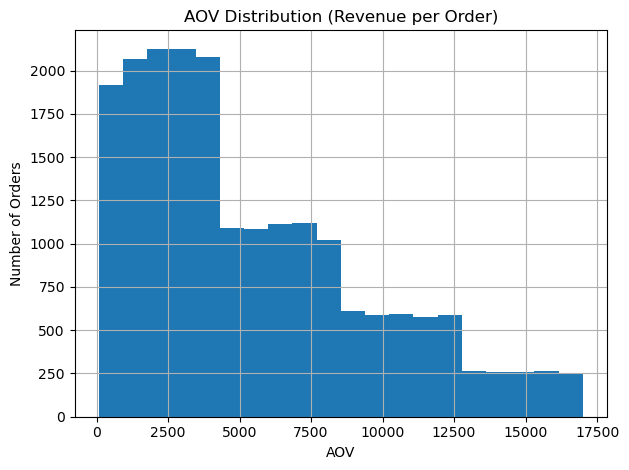


15) AOV Describe:
count    20000.000000
mean      5430.026293
std       4096.155692
min         85.750000
25%       2172.795000
50%       4163.440000
75%       7910.462500
max      16996.550000
Name: Revenue, dtype: float64


In [59]:
# 15. AOV DISTRIBUTION (Average Order Value)
# =========================
order_rev = df.groupby("OrderID")["Revenue"].sum()
aov = order_rev  # Revenue per order

plt.figure()
aov.hist(bins=20)
plt.title("AOV Distribution (Revenue per Order)")
plt.xlabel("AOV")
plt.ylabel("Number of Orders")
plt.tight_layout()
plt.show()

print("\n15) AOV Describe:")
print(aov.describe())

C:\Users\amit singh\AppData\Local\Temp\ipykernel_24508\1225397423.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  discount_impact = df.groupby("DiscountBucket")["Revenue"].agg(["count", "sum", "mean"])



16) Discount Impact by Bucket:
                count           sum         mean
DiscountBucket                                  
0%                  0  0.000000e+00          NaN
0-10%               0  0.000000e+00          NaN
10-20%          20000  1.086005e+08  5430.026293
20-30%              0  0.000000e+00          NaN
30%+                0  0.000000e+00          NaN


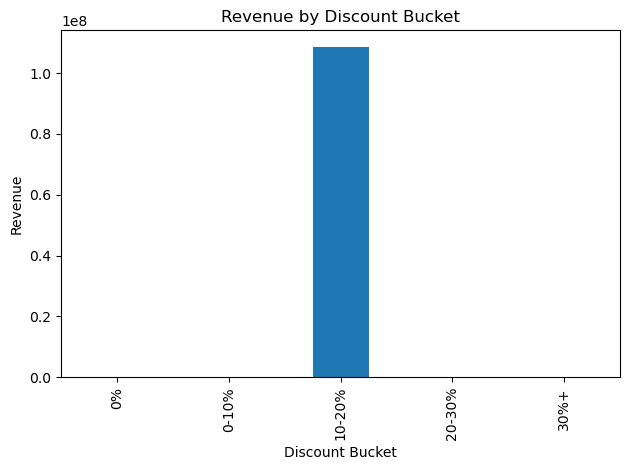

In [60]:
# 16. DISCOUNT IMPACT
# =========================
# Compare revenue by discount bucket
df["DiscountBucket"] = pd.cut(
    df["DiscountRate"],
    bins=[-0.01, 0, 0.1, 0.2, 0.3, 1],
    labels=["0%", "0-10%", "10-20%", "20-30%", "30%+"]
)

discount_impact = df.groupby("DiscountBucket")["Revenue"].agg(["count", "sum", "mean"])

print("\n16) Discount Impact by Bucket:")
print(discount_impact)

plt.figure()
discount_impact["sum"].plot(kind="bar")
plt.title("Revenue by Discount Bucket")
plt.xlabel("Discount Bucket")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()


17) Overall Return Rate: 7.20%

Return Rate by Category (%):
Category
Sports         7.690203
Home           7.280763
Grocery        7.154984
Electronics    7.103659
Fashion        6.847545
Name: IsReturned, dtype: float64


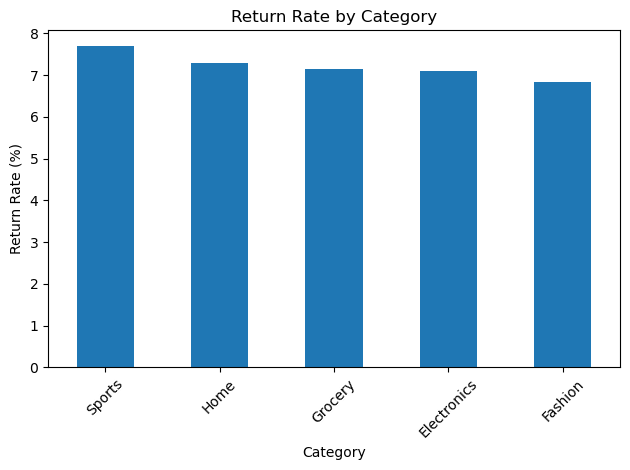

In [61]:
# 17. RETURN RATES
# =========================
overall_return_rate = df["IsReturned"].mean() * 100
print(f"\n17) Overall Return Rate: {overall_return_rate:.2f}%")

return_rate_by_cat = df.groupby("Category")["IsReturned"].mean().sort_values(ascending=False) * 100
print("\nReturn Rate by Category (%):")
print(return_rate_by_cat)

plt.figure()
return_rate_by_cat.plot(kind="bar")
plt.title("Return Rate by Category")
plt.xlabel("Category")
plt.ylabel("Return Rate (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



18) Promo vs Non-Promo Performance:
           count           sum         mean
PromoFlag                                  
Promo      20000  1.086005e+08  5430.026293


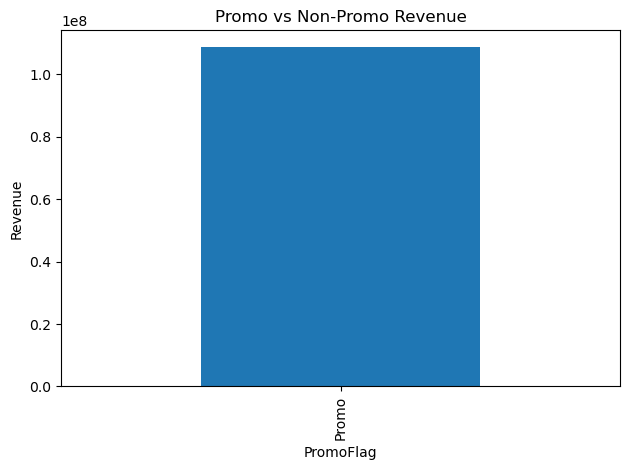

In [62]:
# 18. PROMO vs NON-PROMO
# =========================
# Assumption: any Discount > 0 = Promo
df["PromoFlag"] = np.where(df["Discount"] > 0, "Promo", "Non-Promo")

promo_compare = df.groupby("PromoFlag")["Revenue"].agg(["count", "sum", "mean"])
print("\n18) Promo vs Non-Promo Performance:")
print(promo_compare)

plt.figure()
promo_compare["sum"].plot(kind="bar")
plt.title("Promo vs Non-Promo Revenue")
plt.xlabel("PromoFlag")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()


19) Correlation Matrix:
              Quantity       GMV   Revenue  Discount  DiscountRate
Quantity      1.000000  0.590221  0.590221  0.590221      0.012766
GMV           0.590221  1.000000  1.000000  1.000000      0.011040
Revenue       0.590221  1.000000  1.000000  1.000000      0.011039
Discount      0.590221  1.000000  1.000000  1.000000      0.011042
DiscountRate  0.012766  0.011040  0.011039  0.011042      1.000000


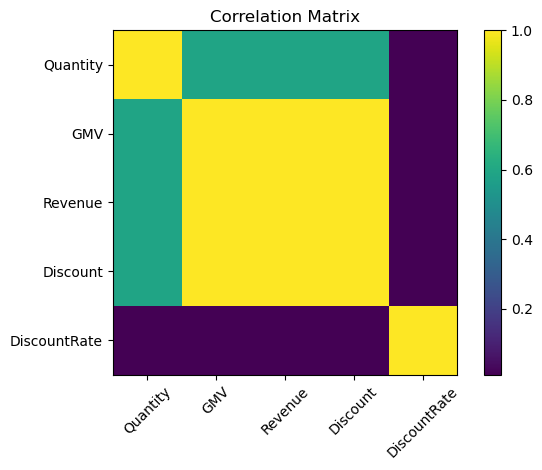

In [63]:
# 19. CORRELATION MATRIX
# =========================
numeric_cols = df[["Quantity", "GMV", "Revenue", "Discount", "DiscountRate"]]
corr_matrix = numeric_cols.corr()

print("\n19) Correlation Matrix:")
print(corr_matrix)

plt.figure()
plt.imshow(corr_matrix, interpolation="nearest")
plt.title("Correlation Matrix")
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
plt.colorbar()
plt.tight_layout()
plt.show()


Anomalous Days:
Empty DataFrame
Columns: [Revenue, RollingMean, RollingStd, Anomaly]
Index: []


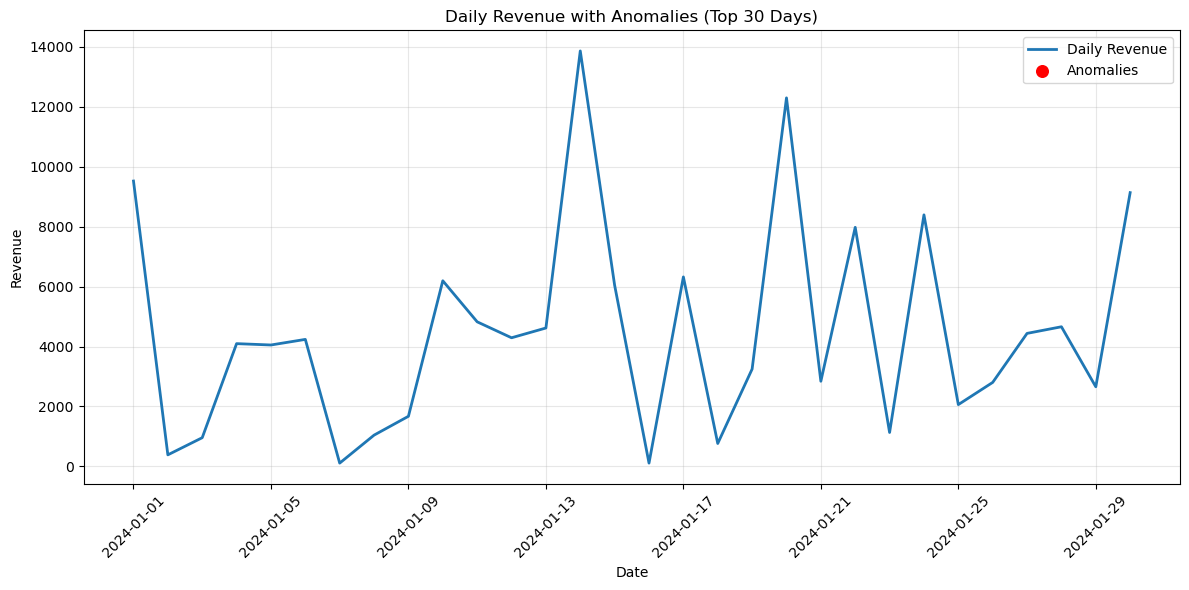

In [54]:
# DAILY REVENUE ANOMALY DETECTION (LESS DATA)

# Convert Date
df['Date'] = pd.to_datetime(df['Date'])

# Daily revenue
daily_revenue = df.groupby("Date")["Revenue"].sum()

# Less data – top 30 days
daily_revenue = daily_revenue.head(30)

# Prepare frame
daily_rev_df = daily_revenue.to_frame(name="Revenue")
daily_rev_df["RollingMean"] = daily_rev_df["Revenue"].rolling(window=7, min_periods=3).mean()
daily_rev_df["RollingStd"] = daily_rev_df["Revenue"].rolling(window=7, min_periods=3).std()

# Anomaly detection
daily_rev_df["Anomaly"] = (
    (daily_rev_df["Revenue"] > daily_rev_df["RollingMean"] + 3*daily_rev_df["RollingStd"]) |
    (daily_rev_df["Revenue"] < daily_rev_df["RollingMean"] - 3*daily_rev_df["RollingStd"])
)

anomalies = daily_rev_df[daily_rev_df["Anomaly"] == True]

print("Anomalous Days:")
print(anomalies)

# Plot
plt.figure(figsize=(12,6))
plt.plot(daily_rev_df.index, daily_rev_df["Revenue"], label="Daily Revenue", linewidth=2)
plt.scatter(anomalies.index, anomalies["Revenue"], color="red", label="Anomalies", s=70)

plt.title("Daily Revenue with Anomalies (Top 30 Days)")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# RECOMMENDATIONS


1.Improve product quality for items with high return rates 
2.Increase inventory for top-selling products to reduce stockouts.
3.Reduce discounts on low-margin items to protect profitability.
4.Focus marketing on high-performing states and cities.
5.Launch retention programs since returning customers drive more revenue.
6.Optimize promotions4keep only those that improve both revenue and margin.
7.Improve product visibility for high-margin but low-sales items.
8.Prepare inventory and staff ahead of peak seasonal months.
9.Re-evaluate product categories with the highest return percentages.
10.Enhance customer experience through faster delivery and better support